<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/BT_MNIST_new3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install fastai==2.6.3 --no-deps
!pip install self_supervised

!pip install pytest
!pip install ipytest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [69]:
import fastai
import self_supervised
import torch
if torch.cuda.is_available():device='cuda'
else:device='cpu'
assert(fastai.__version__ == '2.6.3') #Check that version is 2.6.3
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")

In [70]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")

import ipytest
ipytest.autoconfig()
import pytest

In [71]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))


#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)


#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)


In [109]:
def random_sinusoid(x,std=0.1,seed=0):
    
    seed_everything(seed=seed)    
    t=(std) * torch.randn(1,500).to(device)
    s=(std) * torch.randn(1,500).to(device)
    
    u=torch.randn(1,500).to(device)
    v=torch.randn(1,500).to(device)

    a=(0.1) * torch.randn(1,500).to(device)
    b=(0.1) * torch.randn(1,500).to(device)


    return a*torch.sin(t*x[:,]*math.pi+u) + b*torch.cos(s*x[:,]*math.pi+v)

def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,bs):
    
    C1 = (z1norm.T @ z2norm_2) / bs
    C2 = (z1norm_2.T @ z2norm) / bs
    
    return 0.5*C1.pow(2) + 0.5*C2.pow(2)


class Max_Corr(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(ps,ps)
        self.fc2 = nn.Linear(ps,ps)

        self.fc3 = nn.Linear(ps,ps)
        self.fc4 = nn.Linear(ps,ps)

        self.sigmoid = nn.Sigmoid()

        self.relu = nn.ReLU()
    def forward(self,x,y):

        x=self.sigmoid(self.fc1(x)) #when (sigmoid,relu) GREAT results, with (sigmoid,sigmoid) TERRIBLE. Currently testing (relu,relu)
        x=self.fc2(x)
       
        y=self.relu(self.fc3(y)) #originally had relu and got really good results. If we can't reproduce those results, possible reasons:
                                    #results were due to chance; or having relu on one branch (and sigmoid on the other) helps via breaking
                                      #the symmetry! Other idea: set fc1=fc3, fc2=fc4. 
        y=self.fc4(y)

        return x,y
     

In [110]:
class Cdiff_Rand:
    
    def __init__(self,seed,bs,std=0.1,K=2):
        self.seed=seed
        self.std=std
        self.K=2
        self.bs=bs

    def __call__(self,z1norm,z2norm):
        
        cdiff_rand=0
        for i in range(self.K):

            z1norm_2,z2norm_2 = random_sinusoid(z1norm,std=self.std,seed=self.seed+i), random_sinusoid(z2norm,std=self.std,seed=2*self.seed+i)
            cdiff_rand = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)

        cdiff_rand=(1/self.K)*cdiff_rand
    
        return cdiff_rand
  

In [97]:
class Cdiff_Sup:
    
    def __init__(self,I,inner_steps,bs):
        
        self.I=I
        self.inner_steps=inner_steps
        self.bs=bs
        self.max_corr = Max_Corr()
        if device == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
        max_corr = self.max_corr
        I=self.I
        bs=self.bs
        z1norm=z1norm.detach()
        z2norm=z2norm.detach()
        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
    
        for i in range(self.inner_steps):

            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)   
            
            assert (z1norm_2.shape,z2norm_2.shape) == (z1norm.shape,z2norm.shape)

            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)
            inner_loss=-1*(cdiff_2*(1-I)).mean()
            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()

        for p in max_corr.parameters():
            p.requires_grad=False

        return max_corr(z1norm,z2norm)
    
    def __call__(self,z1norm,z2norm):
        
            z1norm_2,z2norm_2 = self.inner_step(z1norm,z2norm)
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)
    
            return cdiff_sup


In [116]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        print(bs)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2 #We use cdiff to get diagonal components of loss

        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=5,bs=bs) 
        cdiff_sup = CdiffSup(z1norm,z2norm) #`sup` off diagonal components of loss

        CdiffRand = Cdiff_Rand(seed=self.seed,std=0.1,K=2,bs=bs)
        
        cdiff_rand = CdiffRand(z1norm,z2norm)#`random` off diagonal components
        
        cdiff_2 = 0.5*cdiff_rand + 0.5*cdiff_sup #convex combination of random component and sup component. We use
                                                  #cdiff_2 to get off diagonal components of loss. 
        #First summand: Diagonal component    #Second summand: off diag component
        loss = (cdiff*self.I + cdiff_2*(1-self.I)*self.lmb).sum()
        torch.cuda.empty_cache()
        return loss

    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [117]:
#Debugging cell - delete later (similar to cell below)
ps=500
hs=500
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwRMSProp(model.parameters(),lr=0.1, mom=0.9)ins(aug_pipelines, print_augs=True)])
opt = torch.optim.RMSprop
#partial(OptimWrapper, opt=opt)
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
#learn = Learner(dls, model,opt_func=opt_func, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

learn.fit(200) #300                            

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time


512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512


KeyboardInterrupt: ignored

In [77]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def tune_set(items0,tune_s=1000):
    
    items0=items0.shuffle()
    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    ITEMS=[]
    for i in items0:
        s=str(i).split('/training/')[1][0]
        if d[s] is 0 or d[s] is 1:
            ITEMS.append(i)
            d[s]+=1
    #items0=ITEMS

    for i in items0:
        if i not in ITEMS:
            ITEMS.append(i)
            
    split = IndexSplitter(list(range(20)))

    tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
    dls_tune = tds_tune.dataloaders(bs=20, after_item=[ToTensor(), IntToFloatTensor()], device=device)
    
    return dls_tune


In [78]:
#TODO: Do this in a slicker way. Write more tests 
#Get the dataloader and set batch size 
ts=16384 #training set size - most everything
bs=512
device='cuda'
path = untar_data(URLs.MNIST)

items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort() 

seed=42
seed_everything(seed=seed)
labeller = using_attr(RegexLabeller(pat = r'(\d+).png$'), 'name') 

items=items.shuffle()
items1 = items[0:ts] #train on these guys

l=labeller(items1[0])
if seed is 42:
    print('assert passed')
    assert labeller(items1[0]) == '19825' #check that random seed is working

else:
    input('Careful! New random seed ~= 42. Is that ok?')

split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

tune_s=2000 #we choose 20 guys (randomly) out of 1000 to tune on
items0 = items[ts:ts+tune_s] #for fine tuning - just choose 2000 guys to extract 20 for fine tuning 
dls_tune=tune_set(items0,tune_s=tune_s)


#NB: Uncomment and compare in colab and kaggle
# for x,y in dls_tune.train:
#   print(x.mean())
#   input()
#   break

# for x,y in dls_tune.train:
#   print(x.mean())
#   input()
#   break


#Evaluate linear classifier on this guy
test_bs=578
items2 = items[ts+tune_s:]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
tds_test = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=test_bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#Check that test_bs divides length of test set
tem=len(dls_test.train_ds)/test_bs
assert tem-math.floor(tem) == 0

assert passed


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


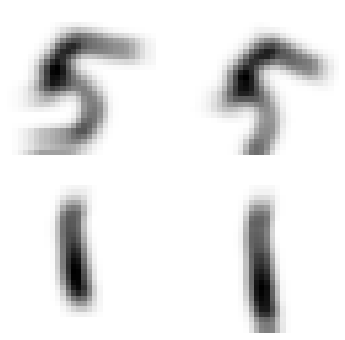

In [ ]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

In [25]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
            
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [59]:
#NB: Will give same random 20-tune set (for fixed random seed), only if the cell
#"#Get the dataloader and set batch size" is the same. Perhaps later we can make this cell a function of that one. 
#Functions to train and evaluate head
fastai_encoder.eval()

def train_head(seed=10): #The seed choses a different (20) samples for training the head. 2 of each class

    seed_everything(seed=seed)
    dls_tune=tune_set(items0,tune_s=tune_s) #different random tune set each time (but random seed same for consistency)
  
    zdim=1024 #see above
    head = LinearClassifier(zdim=zdim)
    device='cuda'
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    #EPOCHS=100

    for epoch in range(200):

        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.valid.one_batch() #Same every time since dataset only has length=batch size = 20
  
        loss = criterion(head(fastai_encoder(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)

    return head

@torch.no_grad()
def eval_head(head):

    N=len(dls_test.train)*test_bs #close to len(dls_test.train_ds) but not quite...

    assert N == len(dls_test.train_ds)

    num_correct=0

    for x,y in dls_test.train:
    #for i in range(3):

        ypred = head(fastai_encoder(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N

In [65]:
%%time
seed=10
performance_dict={}
for num in range(5):

    head=train_head(seed=seed+num)
    pct_correct = eval_head(head)
    performance_dict[f'seed_{num}'] = pct_correct
    
print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict


tensor(0.8312)
CPU times: user 43 s, sys: 3.92 s, total: 46.9 s
Wall time: 1min 29s


{'seed_0': TensorCategory(0.8274),
 'seed_1': TensorCategory(0.7652),
 'seed_2': TensorCategory(0.8897),
 'seed_3': TensorCategory(0.8537),
 'seed_4': TensorCategory(0.8198)}

In [66]:
#Current: With Max_cor = (sigmoid,relu), and fc1=fc3, fc2=fc4

print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict


tensor(0.8312)


{'seed_0': TensorCategory(0.8274),
 'seed_1': TensorCategory(0.7652),
 'seed_2': TensorCategory(0.8897),
 'seed_3': TensorCategory(0.8537),
 'seed_4': TensorCategory(0.8198)}

All of the below have sin and cos with constant coefficients. If we take `best so far` and give it random coefficients a and b with std=0.2 then get:

With fc1,fc2,fc3,fc4 distinct. Indexmod=2, K=2 With Max_corr = (sigmoid,relu);a~b = 0.2 x N(0,1) **0.8390, 0.8553** Conclusion: We need to search over the a and b parameters (coefficients of sinusoids) when we do our big search. Or rather search over std the hps controlling how we sample a and b. 

Results (continuing from prior commit):


Note these are with 200 learn_epochs etc. Same random seed. See above for other details (and we mention when recording the results below that we varied)
BT = 0.7581

(These are with fc1,fc2,fc3,fc4 distinct). Indexmod=2, K=2 
**With Max_corr = (sigmoid,relu): 0.8493,0.8332,0.8392. Best so far.**
With Max_corr = (sigmoid,sigmoid): 0.3080,0.3219.   
With Max_corr = (relu,relu): 0.8132,0.8142,0.8093.   

(These are with fc1=fc3, fc2=fc4. i.e. just one NN applied)  
With Max_corr = (sigmoid,relu): 0.8359,0.8258,0.8303

Above are all with indexmod=2. Now we try removing the indexmod condition.
Then get:
Indexmod=0
With Max_corr = (sigmoid,relu): 0.8264,0.8253 

Try indexmod=4
With Max_corr = (sigmoid,relu):0.8174







Results on different MBT runs (see above for implementation): tensor(0.8493) (trying to reproduce now) (just changed y=self.sigmoid(self.fc3(y))
from relu in MaxCorr). Performance went to tensor(0.3080)!!! Crazy. Let's change y back to relu and see what happens. result: tensor(0.8332)!! Wow. Similar
to before (i.e. evidence in favour of reproducibility). All we changed was sigmoid to relu!

To summarise: Max_Corr had (sigmoid,relu) and got great results (on two diff MBT runs 0.8493 and 0.8332. When we changed relu to sigmoid, got terrible results (0.3080). (As an aside the loss jumped around a lot).

In [ ]:
#250 learn_epochs. To beat: (K=10,indexmod=4,std=0.1,convex=(0.2,0.8))
tem={'seed_0': TensorCategory(0.8364),
 'seed_1': TensorCategory(0.7424),
 'seed_2': TensorCategory(0.8947),
 'seed_3': TensorCategory(0.8392),
 'seed_4': TensorCategory(0.8133)}
print(torch.mean(tensor(list(tem.values())))) #tensor(0.8252)




tensor(0.8252)


tensor(0.8487)

In [ ]:
performance_dict

NameError: ignored